In [ ]:
import os
import csv
import argparse
import numpy as np
from tensorboardX import SummaryWriter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.utils as utils
import torchvision.transforms as torch_transforms
from networks import AttnVGG, VGG
from loss import FocalLoss
from data import preprocess_data_2016, preprocess_data_2017, ISIC
from utilities import *
from transforms import *

print("======>load pretrained models")
net = AttnVGG(num_classes=2, attention=True, normalize_attn=True)
# net = VGG(num_classes=2, gap=False)
checkpoint = torch.load('models/checkpoint.pth')
net.load_state_dict(checkpoint['state_dict'])
pretrained_clf = nn.DataParallel(net).cuda()
pretrained_clf.eval()

print("=======>load ISIC2016 dataset")
normalize = Normalize((0.7012, 0.5517, 0.4875), (0.0942, 0.1331, 0.1521))
transform_test = torch_transforms.Compose([
         RatioCenterCrop(0.8),
         Resize((256,256)),
         CenterCrop((224,224)),
         ToTensor(),
         normalize
    ])
testset = ISIC(csv_file='test.csv', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=8)

total = 0
correct = 0

with open('test_results.csv', 'wt', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for i, data in enumerate(testloader, 0):
        images_test, labels_test = data['image'], data['label']
        images_test, labels_test = images_test.cuda(), labels_test.cuda()
        pred_test, __, __ = pretrained_clf.forward(images_test)
        predict = torch.argmax(pred_test, 1)
        total += labels_test.size(0)
        correct += torch.eq(predict, labels_test).sum().double().item()
        # record test predicted responses
        responses = F.softmax(pred_test, dim=1).squeeze().detach().cpu().numpy()
        responses = [responses[i] for i in range(responses.shape[0])]
        csv_writer.writerows(responses)
        # log images
        if True:
            I_test = utils.make_grid(images_test, nrow=8, normalize=True, scale_each=True)
            #writer.add_image('test/image', I_test, i)
            torchvision.utils.save_image(images_test, "test/test_image.jpg", nrow=8, normalize=True)
            # accention maps
            if True:
                __, a1, a2 = pretrained_clf.forward(images_test)
                if a1 is not None:
                    attn1 = visualize_attn(I_test, a1, up_factor=8, nrow=8)
                    torchvision.utils.save_image(attn1, "test/att1.jpg")
                    #writer.add_image('test/attention_map_1', attn1, i)
                if a2 is not None:
                    attn2 = visualize_attn(I_test, a2, up_factor=2*8, nrow=8)
                    torchvision.utils.save_image(attn2, "test/att2.jpg")
                    #writer.add_image('test/attention_map_2', attn2, i)
AP, AUC, precision_mean, precision_mel, recall_mean, recall_mel = compute_metrics('test_results.csv', 'test.csv')
print("\ntest result: accuracy %.2f%%" % (100*correct/total))
print("\nmean precision %.2f%% mean recall %.2f%% \nprecision for mel %.2f%% recall for mel %.2f%%" %
        (100*precision_mean, 100*recall_mean, 100*precision_mel, 100*recall_mel))
print("\nAP %.4f AUC %.4f\n" % (AP, AUC))


In [ ]:
import libadver.attack as attack
(./xx.jpg)

In [ ]:
import os
import csv
import argparse
import numpy as np
from tensorboardX import SummaryWriter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.utils as utils
import torchvision.transforms as torch_transforms
from networks import AttnVGG, VGG
from loss import FocalLoss
from data import preprocess_data_2016, preprocess_data_2017, ISIC
from utilities import *
from transforms import *
import libadver.attack as attack

modelFile = "/home/lrh/program/git/pytorch-example/adversarial-miccai2019/isic2016/IPMI2019-AttnMel/models/checkpoint.pth"
testCSVFile = "/home/lrh/program/git/pytorch-example/adversarial-miccai2019/isic2016/IPMI2019-AttnMel/test.csv"
trainCSVFile = "/home/lrh/program/git/pytorch-example/adversarial-miccai2019/isic2016/IPMI2019-AttnMel/train.csv"

print("======>load pretrained models")
net = AttnVGG(num_classes=2, attention=True, normalize_attn=True, vis = False)
# net = VGG(num_classes=2, gap=False)
checkpoint = torch.load(modelFile)
net.load_state_dict(checkpoint['state_dict'])
pretrained_clf = nn.DataParallel(net).cuda()
pretrained_clf.eval()

print("=======>load ISIC2016 dataset")
normalize = Normalize((0.7012, 0.5517, 0.4875), (0.0942, 0.1331, 0.1521))
transform_test = torch_transforms.Compose([
         RatioCenterCrop(0.8),
         Resize((256,256)),
         CenterCrop((224,224)),
         ToTensor(),
         normalize
    ])

trainset = ISIC(csv_file=trainCSVFile, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False, num_workers=4)

testset = ISIC(csv_file=testCSVFile, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=4)


## PGD attack
1. dataset attack
2. single image attack

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import csv

pgd_params = {
            'ord': np.inf,
            'y': None,
            'eps': 5.0 / 255,
            'eps_iter': 2.5 / 255,
            'nb_iter': 5,
            'rand_init': True,
            'rand_minmax': 5.0 / 255,
            'clip_min': 0.,
            'clip_max': 1.,
            'sanity_checks': True
        }

import libadver.attack as attack
PGDAttack = attack.ProjectGradientDescent(model = pretrained_clf)

total = 0
correct = 0
resultPath = 'adversarial_result/PGD/test_delete.csv'

with open(resultPath, 'wt', newline='') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    for i, data in enumerate(testloader, 0):
        image, label = data['image'], data['label']
        image, label = image.cuda(), label.cuda()
        
        pgd_params['y'] = label
        pgd_params['clip_min'] = torch.min(image) 
        pgd_params['clip_max'] = torch.max(image)
        
        adv_x = PGDAttack.generate(image, **pgd_params)
        
        pred_test, __, __ = pretrained_clf(adv_x)
        predict = torch.argmax(pred_test, 1)
        total += label.size(0)
        correct += torch.eq(predict, label).sum().double().item()
        # record test predicted responses
        responses = F.softmax(pred_test, dim=1).squeeze().detach().cpu().numpy()
        responses = [responses[i] for i in range(responses.shape[0])]
        csv_writer.writerows(responses)
        # log images
#         I_test = utils.make_grid(image, nrow=8, normalize=True, scale_each=True)
#         #writer.add_image('test/image', I_test, i)
#         torchvision.utils.save_image(image, "adversarial_result/PGD/test_image.jpg", nrow=8, normalize=True)
#         torchvision.utils.save_image(adv_x, "adversarial_result/PGD/adv_image.jpg", nrow=8, normalize=True)
        
#         # original attention maps
#         __, a1, a2 = pretrained_clf(image)
#         if a1 is not None:
#             attn1 = visualize_attn(I_test, a1, up_factor=8, nrow=8)
#             torchvision.utils.save_image(attn1, "adversarial_result/PGD/att1.jpg")
#             #writer.add_image('test/attention_map_1', attn1, i)
#         if a2 is not None:
#             attn2 = visualize_attn(I_test, a2, up_factor=2*8, nrow=8)
#             torchvision.utils.save_image(attn2, "adversarial_result/PGD/att2.jpg")
            
#         # adversarial attention maps
#         __, a1, a2 = pretrained_clf(adv_x)
#         if a1 is not None:
#             attn1 = visualize_attn(I_test, a1, up_factor=8, nrow=8)
#             torchvision.utils.save_image(attn1, "adversarial_result/PGD/adv_att1.jpg")
#             #writer.add_image('test/attention_map_1', attn1, i)
#         if a2 is not None:
#             attn2 = visualize_attn(I_test, a2, up_factor=2*8, nrow=8)
#             torchvision.utils.save_image(attn2, "adversarial_result/PGD/adv_att2.jpg")
#         break
                    #writer.add_image('test/attention_map_2', attn2, i)
# AP, AUC, precision_mean, precision_mel, recall_mean, recall_mel = compute_metrics(resultPath, 'test.csv')
# print("\ntest result: accuracy %.2f%%" % (100*correct/total))
# print("\nmean precision %.2f%% mean recall %.2f%% \nprecision for mel %.2f%% recall for mel %.2f%%" %
#         (100*precision_mean, 100*recall_mean, 100*precision_mel, 100*recall_mel))
# print("\nAP %.4f AUC %.4f\n" % (AP, AUC))

In [ ]:
from utilities import *
resultPath = "adversarial_result/PGD/test_m5n5.csv"
testCSVFile = "/home/lrh/program/git/pytorch-example/adversarial-miccai2019/isic2016/IPMI2019-AttnMel/test.csv"
AP, AUC, precision_mean, precision_mel, recall_mean, recall_mel = compute_metrics(resultPath, testCSVFile)
#print("\ntest result: accuracy %.2f%%" % (100*correct/total))
print("\nmean precision %.2f%% mean recall %.2f%% \nprecision for mel %.2f%% recall for mel %.2f%%" %
        (100*precision_mean, 100*recall_mean, 100*precision_mel, 100*recall_mel))
print("\nAP %.4f AUC %.4f\n" % (AP, AUC))

### Single Image Attack

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import csv
from transforms import *
import libadver

pgd_params = {
            'ord': np.inf,
            'y': None,
            'eps': 5.0 / 255,
            'eps_iter': 1.25 / 255,
            'nb_iter': 10,
            'rand_init': True,
            'rand_minmax': 5.0 / 255,
            'clip_min': 0.,
            'clip_max': 1.,
            'sanity_checks': True
        }

pgd_params['y'] = torch.LongTensor([1,1,1,1,1]).cuda()


import libadver.attack as attack
PGDAttack = attack.ProjectGradientDescent(model = pretrained_clf)
isBenign = False
benignRoot = "./adversarial_result/ori_img/benign"
malignantRoot = "./adversarial_result/ori_img/malignant"

benignImgs = [
    "ISIC_0000234.jpg","ISIC_0000254.jpg", "ISIC_0000271.jpg", 
    "ISIC_0000325.jpg","ISIC_0000319.jpg"
]
malignImgs = [
    "ISIC_0000549.jpg", "ISIC_0001103.jpg", "ISIC_0001142.jpg",
    "ISIC_0000547.jpg", "ISIC_0001100.jpg"
]

if isBenign is True:
    Imgs = benignImgs
    Root = benignRoot
else:
    Imgs = malignImgs
    Root = malignantRoot

from torchvision.transforms import transforms
mean = [0.7012, 0.5517, 0.4875]
std = [0.0942, 0.1331, 0.1521]
normalize = Normalize(mean, std)
transform_test = transforms.Compose([
         RatioCenterCrop(0.8),
         Resize((256,256)),
         CenterCrop((224,224)),
         ToTensor(),
         normalize
    ])

images = torch.zeros([5,3,224,224])
labels = torch.zeros([5])
from PIL import Image
for batchIdx, Img in enumerate(Imgs):
    benignPath = os.path.join(Root, Img)
    img = Image.open(benignPath)
    sample = {'image': img, 'image_seg': img, 'label': 0}
    t_sample = transform_test(sample)
    img = t_sample["image"]
    #img.unsqueeze_(0)
    images[batchIdx] = img
    labels[batchIdx] = t_sample['label']
    #print(images.shape)
# print(img1.shape)
images = images.cuda()
pgd_params['clip_min'] = torch.min(images) 
pgd_params['clip_max'] = torch.max(images)

# img1_temp = torch.zeros(img1.size())
# for c2 in range(3):
#     img1_temp.data[:,c2,:,:] = (img1.data[:,c2,:,:] * std[c2]) + mean[c2]
# torchvision.utils.save_image(img1_temp, "test/ori_img.jpg", normalize=True,  scale_each=True)


adv_images = PGDAttack.generate(images, **pgd_params)

#torchvision.utils.save_image(images, "adversarial_result/PGD/ori_img.png", normalize=True,  scale_each=True)
#torchvision.utils.save_image(adv_images, "adversarial_result/PGD/adv_img.png", normalize=True,  scale_each=True)
delta_ims = adv_images - images
#torchvision.utils.save_image(delta_ims, "adversarial_result/PGD/delta_im.png", normalize=True,  scale_each=True)


pred_test, a1, a2 = pretrained_clf(images)
print(torch.softmax(pred_test, dim=1))
predict = torch.argmax(pred_test, 1)
print(predict)

pred_test, a1, a2 = pretrained_clf(adv_images)
print(torch.softmax(pred_test, dim=1))
predict = torch.argmax(pred_test, 1)
print(predict)

images = images.cpu()
adv_images = adv_images.cpu()
delta_ims = delta_ims.cpu()

for i in range(5):
    image = images[i]
    image_PIL = libadver.visutils.recreate_image(image,mean,std)
    libadver.visutils.save_image(image_PIL,"adversarial_result/pre_img/malignant/ori_img_%d.png" %i)
    
    adv_image = adv_images[i]
    adv_image_PIL = libadver.visutils.recreate_image(adv_image,mean,std)
    libadver.visutils.save_image(adv_image_PIL,"adversarial_result/PGD/malignant/adv_img_%d.png" %i)
    
    delta_im = delta_ims[i].data.numpy()
    libadver.visutils.save_gradient_images(delta_im,"adversarial_result/PGD/malignant/delta_im_%d.png" %i)
    
    

#I_test = utils.make_grid(img1.detach(), nrow=8, normalize=True, scale_each=True)

# for c2 in range(3):
#     img1_temp.data[:,c2,:,:] = (img1.data[:,c2,:,:] * std[c2]) + mean[c2]
# torchvision.utils.save_image(img1_temp, "test/adv_img.jpg", normalize=True,  scale_each=True)

# if a1 is not None:
#     attn1 = visualize_attn(I_test, a1, up_factor=8, nrow=8)
#     torchvision.utils.save_image(attn1, "test/adv_att1.jpg")
#     #writer.add_image('test/attention_map_1', attn1, i)
# if a2 is not None:
#     attn2 = visualize_attn(I_test, a2, up_factor=2*8, nrow=8)
#     torchvision.utils.save_image(attn2, "test/adv_att2.jpg")

## test draw text

In [ ]:
from PIL import Image
import os
from libadver import visutils

malignantRoot = "./adversarial_result/pre_img/malignant"
malignImgs = [
    "ori_img_0.png", "ori_img_1.png", "ori_img_2.png",
    "ori_img_3.png", "ori_img_4.png"
]
malignantAdvRoot = "./adversarial_result/PGD/malignant"
malignAdvImgs = [
    "adv_img_0.png", "adv_img_1.png", "adv_img_2.png",
    "adv_img_3.png", "adv_img_4.png"
]


# malignImg = malignImgs[0]
# malignPath = os.path.join(malignantRoot, malignImg)
# img = Image.open(malignPath)
# text = "Malignant:98.93%"
# img_text = visutils.draw_text(img,text,'green',length=180)
# img_text.save(os.path.join(malignantRoot, "ori_img_0_text.png"))

malignAdvImg = malignAdvImgs[0]
malignAdvPath = os.path.join(malignantAdvRoot, malignAdvImg)
advImg = Image.open(malignAdvPath)
text = "Benign:100%"
advImg_text = visutils.draw_text(advImg,text,'red',length=180)
advImg_text.save(os.path.join(malignantAdvRoot, "adv_img_0_text.png"))

## GAP attack
1. dataset attack
2. single image attack

In [ ]:
import libadver.attack as attack
import libadver.models.generators as generators
import torch.optim as optim
import torch.nn as nn

mean = (0.7012, 0.5517, 0.4875)
std = (0.0942, 0.1331, 0.1521)
isTrain = True
import torch

params = {
        "attackModelPath" : None,
        "mag_in" : 7.0,
        "ord" : "inf",
        "epochNum" : 3,
        "criterion" : nn.CrossEntropyLoss(),
        "ncInput" : 3,
        "ncOutput" : 3,
        "mean" : mean,
        "std" : std,
        "MaxIter" : 100
    }
print(params)
saveModelPath = "adversarial_result/GAP/GAP_im_m7n3.pth"
attackModel = generators.define(input_nc = params["ncInput"], output_nc = params["ncOutput"],
                                ngf = 64, gen_type = "unet", norm="batch", act="relu", gpu_ids = [0])
    

if isTrain is True:
    print("===>Train")
    optimizerG = optim.Adam(attackModel.parameters(), lr = 2e-4, betas = (0.5, 0.999))
    params["optimizerG"] = optimizerG
    GAPAttack = attack.GenerativeAdversarialPerturbations(pretrained_clf, attackModel, **params)
    GAPAttack.train(trainloader, saveModelPath)
else:
    print("===>Test")
    ## test
    params["attackModelPath"] = saveModelPath
    GAPAttack = attack.GenerativeAdversarialPerturbations(pretrained_clf, attackModel, **params)
    correct = 0
    total = 0
    for i, data in enumerate(testloader):
        images, targets = data['image'].cuda(), data['label'].cuda()
        adv_images = GAPAttack.generate(images)
        predicted,_,_ = pretrained_clf(adv_images)
        predicted_labels = torch.argmax(predicted,1)
        #print(predicted_labels)
        correct += torch.sum(predicted_labels.eq(targets))
        #print(targets)
        total += images.shape[0]
        print("ACC:%.3f | %d,%d" %(100.0*float(correct) / total, correct, total))

## visulization

ori_img + conv1 feas + saliency maps + attention maps + Guided gradCam

//vistools

### saliency maps

In [ ]:
import libadver.visutils as visutils

In [ ]:
from PIL import Image
from transforms import *
from torchvision.transforms import transforms
benignImg = "./test/ori_img/ISIC_0000016_be.jpg" #0
malignImg = "./test/ori_img/ISIC_0000074_ma.jpg" #1
target_class = 1
img1 = Image.open(malignImg)

mean = (0.7012, 0.5517, 0.4875)
std = (0.0942, 0.1331, 0.1521)
normalize = Normalize(mean, std)
transform_test = transforms.Compose([
         RatioCenterCrop(0.8),
         Resize((256,256)),
         CenterCrop((224,224)),
         ToTensor(),
         normalize
    ])

sample = {'image': img1, 'image_seg': img1, 'label': 0}

t_sample = transform_test(sample)
img1 = t_sample["image"]
img1.unsqueeze_(0)
img1 = img1.cuda()

x = img1
x.requires_grad = True
output,_,_ = pretrained_clf(x)


one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
one_hot_output[0][target_class] = 1
one_hot_output = one_hot_output.cuda()
# Backward pass
output.backward(gradient=one_hot_output)
print(x.grad.data.shape)
gradient_arr = x.grad.data.cpu().numpy()[0]
gradient_arr_grey = visutils.convert_to_grayscale(gradient_arr)
print(gradient_arr_grey.shape)
gradient_arr_grey = 1 - gradient_arr_grey
visutils.save_gradient_images(gradient_arr_grey, "test/malignImg_grey.jpg")

### feature map

In [ ]:
from PIL import Image
from transforms import *
from torchvision.transforms import transforms
benignImg = "./test/ori_img/ISIC_0000016_be.jpg" #0
malignImg = "./test/ori_img/ISIC_0000074_ma.jpg" #1
target_class = 1
img1 = Image.open(malignImg)

mean = (0.7012, 0.5517, 0.4875)
std = (0.0942, 0.1331, 0.1521)
normalize = Normalize(mean, std)
transform_test = transforms.Compose([
         RatioCenterCrop(0.8),
         Resize((256,256)),
         CenterCrop((224,224)),
         ToTensor(),
         normalize
    ])

sample = {'image': img1, 'image_seg': img1, 'label': 0}

t_sample = transform_test(sample)
img1 = t_sample["image"]
img1.unsqueeze_(0)
img1 = img1.cuda()

x = img1
_,_,_,block1,block2,block3,block4,block5 = pretrained_clf(x)

print(block1.shape)
import torchvision
block1 = block1.permute([1,0,2,3])
torchvision.utils.save_image(block1,"test/block1.jpg")

block2 = block2.permute([1,0,2,3])
torchvision.utils.save_image(block2,"test/block2.jpg")

block3 = block3.permute([1,0,2,3])
torchvision.utils.save_image(block3,"test/block3.jpg",nrow=32)

block4 = block4.permute([1,0,2,3])
torchvision.utils.save_image(block4,"test/block4.jpg",nrow=32)

block5 = block5.permute([1,0,2,3])
torchvision.utils.save_image(block5,"test/block5.jpg",nrow=32)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)[0:7]
print(crashes.head())
# 加载数据

f, ax = plt.subplots(figsize=(6, 3))
# 创建图表

sns.set_color_codes("pastel")
sns.barplot(x="total", y="abbrev", data=crashes,
            label="Total", color="b",edgecolor = 'w')
# 设置第一个柱状图

sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b",edgecolor = 'w')
# 设置第二个柱状图

ax.legend(ncol=1, loc="lower right")
sns.despine(left=True, bottom=True)

plt.show()

In [ ]:
import torchvision.models as models

resnext = models.resnext101_32x8d(pretrained=True)

#print(resnext)

resnet = models.resnet18()
#print(resnet)

print(resnext)

In [ ]:
import numpy as np
acc_np = np.array([
    [27.968,34.301,36.939,30.343,30.871],
    [27.177,27.177,26.385,25.330,30.607],
    [28.760,22.691,25.330,22.691,30.607],
    [22.955,27.704,23.219,27.441,24.274]
])

import pandas
data_df = pandas.read_csv("test.csv")

print(acc_np.mean(axis=1))

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
fmri = sns.load_dataset("fmri")

#print(fmri)

ax = sns.lineplot(x="lambda", y="acc", markers=True, dashes=False, data=data_df)

ax

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
x = np.array([5.0,7.0,10.0,13.0])

matplotlib.rc('axes',titlesize=18)
matplotlib.rc('axes', labelsize=18)
matplotlib.rc('xtick',labelsize=18)
matplotlib.rc('ytick',labelsize=18)

fig, axs = plt.subplots(1,3,figsize=(18,4.5),constrained_layout=True)
axs = axs.flatten()

ax = axs[0]
    
data = np.array([32.0844,27.3352,26.0158,25.1186])
data2 = np.array([32.0844 + 0.5,27.3352-0.2,26.0158-0.5,25.1186+2.2])

plt.grid(False)
#plt.axis('off')

ax.plot(x, data, marker='*', color="red", label="train Acc:100%")
ax.plot(x, data2, marker='v', color="blue", label="test Acc:85.7%")


ax.set_xticks(x)
ax.set_yticks([20.0,25.0,30.0,35.5])
ax.set_xlabel('Lambda')
ax.set_ylabel('Accuracy')
ax.legend(fontsize=15)
 


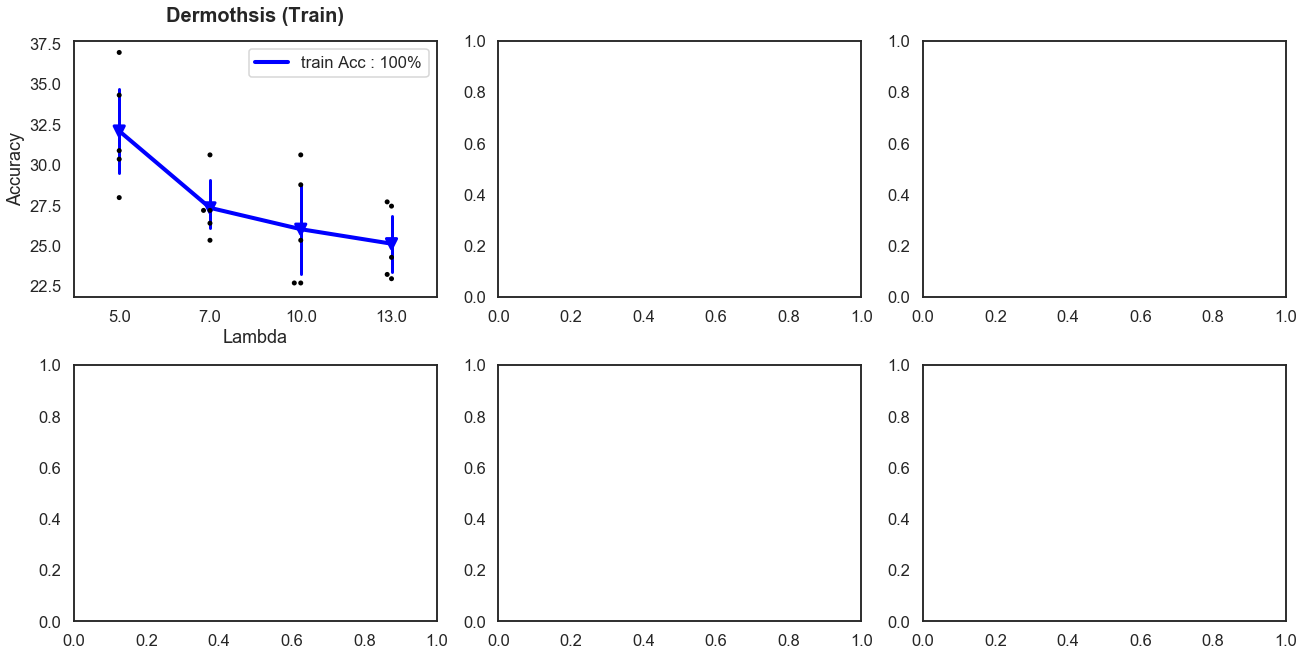

In [22]:
import seaborn as sns
import numpy as np
sns.set(style="white")
sns.axes_style('white')
sns.set_context("talk")
#sns.set_style("ticks", {"xtick.major.size": 18, "ytick.major.size": 8})
tips = sns.load_dataset("tips")
import matplotlib
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,3,figsize=(18,9),constrained_layout=True)
axs = axs.flatten()

matplotlib.rc('axes',titlesize=18)
matplotlib.rc('axes', labelsize=18)
matplotlib.rc('xtick',labelsize=18)
matplotlib.rc('ytick',labelsize=18)

ax = axs[0]
import pandas
data_df = pandas.read_csv("test.csv")
x = np.array([5.0,7.0,10.0,13.0])
data = np.array([32.0844,27.3352,26.0158,25.1186])
#print(data_df)
g1 = sns.swarmplot(x="lambda", y="acc", data=data_df,color="black",ax=ax)
#print(tips)
#g1 = sns.pointplot(x,data, color="red", markers="v",ax=ax,label = "train")
g1 = sns.pointplot(x="lambda", y="acc", data=data_df, color="blue",ax=ax, markers="v",errwidth=3.0)
#g = sns.catplot(x="lambda", y="acc", data=data_df,color="red",ax=ax)
#g2 = sns.swarmplot(x="lambda", y="acc", data=data_df,color="blue",ax=ax)
#g2 = sns.pointplot(x="lambda", y="acc", data=data_df, color="blue",ax=ax, markers="v",errwidth=3.0)

g1.set_xticklabels(x)
#ax.set_xticks(x)
#ax.set_yticks([20.0,25.0,30.0,35.5])
ax.set_xlabel('Lambda')
ax.set_ylabel('Accuracy')
ax.legend(labels=["train Acc : 100%"])

#ax.tick_params(direction='in')
ax.set_title("Dermothsis (Train)", y=1.05,fontweight='bold', fontsize=20)
name = "sample.pdf"
fig.savefig(name,format='pdf', bbox_inches='tight', pad_inches = 0)